<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Sentiment analysis con Embeddings + LSTM

### Objetivo
El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [1]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [2]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')

### Datos
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\
Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [3]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [4]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


### 1 - Limpieza de datos
Alumno:
- Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
- Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [5]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [6]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

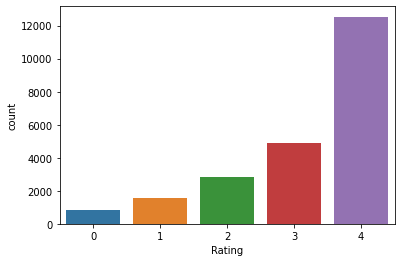

In [7]:
df_reviews['Rating'].value_counts()
sns.countplot(x='Rating', data=df_reviews)
plt.show()

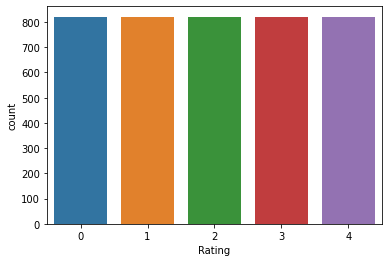

In [8]:
tag_0 = df_reviews[df_reviews['Rating'] == 0]
tag_1 = df_reviews[df_reviews['Rating'] == 1].iloc[0:len(tag_0)]
tag_2 = df_reviews[df_reviews['Rating'] == 2].iloc[0:len(tag_0)]
tag_3 = df_reviews[df_reviews['Rating'] == 3].iloc[0:len(tag_0)]
tag_4 = df_reviews[df_reviews['Rating'] == 4].iloc[0:len(tag_0)]
df_reviews = pd.concat([tag_0,tag_1,tag_2,tag_3,tag_4])
df_reviews['Rating'].value_counts()
sns.countplot(x='Rating', data=df_reviews)
plt.show()


In [9]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews['Review Text'].values
text_sequences.shape

(4105,)

In [10]:
# Alumno: Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

4105

In [11]:
# Alumno: Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)


In [12]:
# Alumno: ¿Cuál es la longitud de ese corpus?
len(corpus)

1287596

In [13]:
# Alumno: Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [14]:
# Alumno: Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['3',
 'tags',
 'sewn',
 'in',
 '2',
 'small',
 'about',
 "1''",
 'long',
 'and',
 '1',
 'huge',
 'about',
 "2''",
 'x',
 "3''",
 'very',
 'itchy',
 'so',
 'i']

In [15]:
# Alumno: ¿Cuántos tokens/palabras hay?
len(tokens)

251778

In [16]:
# Alumno: Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# num_words --> the maximum number of words to keep, based on word frequency.
# Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 2000
vocab_size = num_words
tok = Tokenizer(num_words=2000) 
tok.fit_on_texts(tokens)

In [17]:
# Alumno: Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

7201

In [37]:
text_sequences[0]

"3 tags sewn in, 2 small (about 1'' long) and 1 huge (about 2'' x 3''). very itchy so i cut them out. then the thread left behind was plasticy and even more itchy! how can you make an intimates item with such itchy tags? not comfortable at all! also - i love bralettes and wear them all the time including to work. i am a b cup. however, this one is so thin and flimsy that it gives no support even to a b cup - so for me this would only be a lounging bralette - if it wasn't so itchy!"

In [18]:
# Alumno: Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [19]:
# Alumno: Determinar cual es la oración más larga
max(len(s) for s in sequences)

110

In [21]:
# Alumno: Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
# from keras_preprocessing.sequence import pad_sequences

maxlen = max(len(s) for s in sequences)

X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [22]:
# Alumno: Observar las dimensiones de la variable input
X.shape


(4105, 110)

In [23]:
# Alumno tomar la columna rating y alcemacenarla en una variable "y" transformada a oneHotEncoding
# Su shape debe ser equivalente la cantidad de rows del corpus y a la cantidad
# de clases que se deseen predecir (en este ejemplo son 5)

from keras.utils.np_utils import to_categorical   

y = to_categorical(df_reviews['Rating'], num_classes=5)

In [24]:
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [121]:
# Alumno: Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=54, stratify=y, shuffle=True)

In [122]:
# Alumno: determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = y_train.shape[1] # categorical classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 110 , out_shape 5


### 2 - Entrenar el modelo con Embeddings + LSTM

In [127]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Downloading...
From: https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download
To: c:\Users\zerba\Documents\UBA\Repos\Repositorios de Eloy\NLP-UBA\clase_5\fasttext.pkl
100%|██████████| 2.88G/2.88G [04:22<00:00, 11.0MB/s]


In [128]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [129]:
model_fasttext = FasttextEmbeddings()

In [130]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [131]:
Embedding(input_dim=vocab_size,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=in_shape, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

In [136]:
# Entrenar un modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

opt = keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name='Adam',
)

model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()



Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 110, 300)          600000    
                                                                 
 lstm_33 (LSTM)              (None, 110, 64)           93440     
                                                                 
 dropout_32 (Dropout)        (None, 110, 64)           0         
                                                                 
 lstm_34 (LSTM)              (None, 64)                33024     
                                                                 
 dense_28 (Dense)            (None, 128)               8320      
                                                                 
 dropout_33 (Dropout)        (None, 128)               0         
                                                                 
 dense_29 (Dense)            (None, 5)               

In [137]:
hist = model2.fit(X_train, y_train, epochs=30, validation_split=0.2)

Epoch 1/30
83/83 [==============================] - 12s 109ms/step - loss: 1.6133 - accuracy: 0.2059 - val_loss: 1.6163 - val_accuracy: 0.1796
Epoch 2/30
83/83 [==============================] - 8s 100ms/step - loss: 1.6063 - accuracy: 0.2059 - val_loss: 1.6176 - val_accuracy: 0.1933
Epoch 3/30
83/83 [==============================] - 9s 114ms/step - loss: 1.5994 - accuracy: 0.2215 - val_loss: 1.6297 - val_accuracy: 0.2344
Epoch 4/30
83/83 [==============================] - 9s 111ms/step - loss: 1.6052 - accuracy: 0.2231 - val_loss: 1.6055 - val_accuracy: 0.2207
Epoch 5/30
83/83 [==============================] - 9s 112ms/step - loss: 1.5842 - accuracy: 0.2432 - val_loss: 1.5848 - val_accuracy: 0.2572
Epoch 6/30
83/83 [==============================] - 9s 107ms/step - loss: 1.5714 - accuracy: 0.2653 - val_loss: 1.5811 - val_accuracy: 0.2451
Epoch 7/30
83/83 [==============================] - 10s 115ms/step - loss: 1.5508 - accuracy: 0.2752 - val_loss: 1.5666 - val_accuracy: 0.2420
Epoc

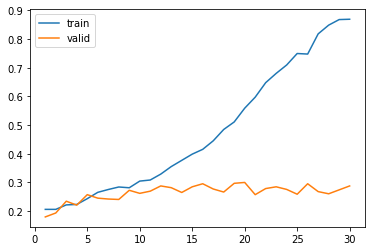

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [139]:
model2.evaluate(X_test, y_test)

26/26 [==============================] - 1s 42ms/step - loss: 3.1542 - accuracy: 0.2643


[3.1542391777038574, 0.264311820268631]

In [146]:
text_input = ['I am very happy']
sequences = tok.texts_to_sequences(text_input)
X_input = pad_sequences(sequences, padding='pre', maxlen=maxlen)
pred = model2.predict(X_input)
print(pred)
print(text_input[0] + '-> '+'*'*(np.argmax(pred)+1))

1/1 [==============================] - 0s 25ms/step
[[0.08352753 0.01194332 0.08734768 0.45794874 0.35923275]]
I am very happy-> ****


In [148]:
text_input = ['I will not recomend this place']
sequences = tok.texts_to_sequences(text_input)
X_input = pad_sequences(sequences, padding='pre', maxlen=maxlen)
pred = model2.predict(X_input)
print(pred)
print(text_input[0] + '-> '+'*'*(np.argmax(pred)+1))

1/1 [==============================] - 0s 27ms/step
[[0.63463026 0.22582698 0.01766499 0.00875944 0.11311827]]
I will not recomend this place-> *


In [149]:
text_input = ['this is the worst shoes in the world']
sequences = tok.texts_to_sequences(text_input)
X_input = pad_sequences(sequences, padding='pre', maxlen=maxlen)
pred = model2.predict(X_input)
print(pred)
print(text_input[0] + '-> '+'*'*(np.argmax(pred)+1))

1/1 [==============================] - 0s 50ms/step
[[0.3949866  0.17904612 0.03669126 0.29910094 0.090175  ]]
this is the worst shoes in the world-> *


In [150]:
text_input = ['this is the bes shoes in the world']
sequences = tok.texts_to_sequences(text_input)
X_input = pad_sequences(sequences, padding='pre', maxlen=maxlen)
pred = model2.predict(X_input)
print(pred)
print(text_input[0] + '-> '+'*'*(np.argmax(pred)+1))

1/1 [==============================] - 0s 27ms/step
[[0.30488962 0.20574458 0.0800201  0.05732782 0.35201785]]
this is the bes shoes in the world-> *****
